# Character recognition using convolutional neural networks

I wrote this notebook for street view character recognition Kaggle competetion <a>https://www.kaggle.com/c/street-view-getting-started-with-julia</a>

To run this you should have libraries as listed below installed:
* pandas
* sklearn
* PIL
* Theano or TensorFlow as Keras backend
* Keras

In [1]:
from __future__ import division
import numpy as np
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import keras

## 1. Retrieving data
Our data consists of about 4k train images and 6k of test images. Wich train image labeled with its character in file trainlabels.csv. Code below creates a list of all labels, wich will need later to make one-hot encoding 

In [2]:
import pandas as pd
train_frame=pd.read_csv('trainLabels.csv')
letters=sorted(list(set(train_frame['Class'])))
print letters
train_frame.head()

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


,ID,Class
0,1,n
1,2,8
2,3,T
3,4,I
4,5,R


As for image itself, they are all of different sizes and colorful. Though we don't really need their color to predict letters, just shape, so let's convert all images to grayscale and resize them to 64x64 pixels. The function below loads all train images, resizes, turns them in grayscale and preprocesses them if needed and specified function is send as parameter. But I really haven't find appropriate filters to improve accuracy. 

In [3]:
from skimage.filters import threshold_otsu,gaussian_filter,threshold_adaptive
from skimage.exposure import equalize_hist

def load_train_val_ims(train_frame=train_frame,im_folder='train/',to_resize=64, preprocessor=None):
    X_train=[]    
    y_train=[]    
    for im,y in zip(train_frame['ID'],train_frame['Class']):        
        i=np.array(Image.open(im_folder+str(im)+'.Bmp').convert('L').resize((to_resize,to_resize)))
        if preprocessor:
            i=preprocessor(i)
        X_train.append((i/255).reshape(1,to_resize,to_resize))
        y_t=np.zeros(len(letters))
        y_t[letters.index(y)]=1
        y_train.append(y_t)
    return np.array(X_train), np.array(y_train)    

def preprocess(image):    
    image=gaussian_filter(image,0.9)
    return image

In [4]:
#X_train,y_train=load_train_val_ims(preprocessor=preprocess)
X_train,y_train=load_train_val_ims()

Let's see what our images looks like

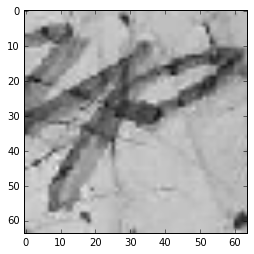

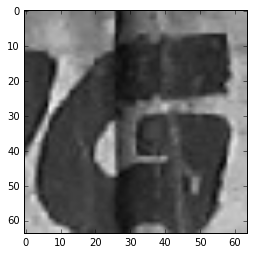

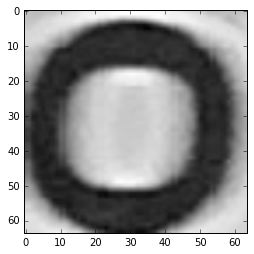

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in np.random.randint(0,len(X_train),3):
    plt.imshow(X_train[i].reshape(64,64))
    plt.gray()
    plt.show()

In [6]:
from sklearn.cross_validation import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.3)

To augument our data a bit we can use Keras ImageDataGenerator.Let's add some rotation angle and horizontal and vertical shifts

In [7]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    
    # fit the model on the batches generated by datagen.flow()


## 2. Defining a model

Current neural net consists of 3 convolutional layers followed by exponential linear unit activation and maxpooling with 2 fully connected layers in the end. First counvolutional layer is 32 4x4 filters, other 2 layers 64 3x3 filters. 

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD

img_channels, img_rows, img_cols=1,64,64

Using Theano backend.
/home/alex/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [9]:
from keras.layers.advanced_activations import ELU,LeakyReLU

def get_model():    
    model = Sequential()
    
    model.add(Convolution2D(32, 4, 4, border_mode='same',
                            input_shape=(img_channels, img_rows, img_cols)))
    model.add(Activation(ELU()))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))        
    
    model.add(Convolution2D(64, 3, 3))
    model.add(Activation(ELU()))    
    
    model.add(MaxPooling2D(pool_size=(2, 2)))        
    
    model.add(Convolution2D(64, 3, 3))
    model.add(Activation(ELU()))
    model.add(MaxPooling2D(pool_size=(2, 2)))        
    
    model.add(MaxPooling2D(pool_size=(2, 2)))        
    
    model.add(Flatten())
    
    model.add(Dropout(0.5))
    
    model.add(Dense(1024))
    model.add(Activation('relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1024))
    model.add(Activation('relu'))

    
    model.add(Dense(len(letters)))
    model.add(Activation('softmax'))    
    return model

## 3. Training
To train network I used adadelta optimizer with scheduler wich every 20 epochs decreases learning weight and early stopping, wich worked if validation loss haven't improved for 3 epochs.

In [10]:
from keras.callbacks import LearningRateScheduler
from keras import callbacks

def scheduler(epoch):
    if epoch%20==0:
        return float(model.optimizer.lr.get_value()/2.5)
    return float(model.optimizer.lr.get_value())


def train_model(model, X_train=X_train, y_train=y_train,\
                X_val=X_val, y_val=y_val,\
                optimizer='adadelta',\
                nb_epochs=70,\
                early_stopping_patience=3,\
                model_name='model',\
                scheduler=scheduler):
    try:
        model.compile(loss='categorical_crossentropy',optimizer=optimizer)
        
        if scheduler:
            change_lr = LearningRateScheduler(scheduler)
        else:
            change_lr=LearningRateScheduler(lambda x:model.optimizer.lr.get_value())
        
        remote = callbacks.RemoteMonitor(root='http://localhost:9000')
        check=callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
    
    
        history=model.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                        samples_per_epoch=X_train.shape[0],nb_epoch=nb_epochs,
                  callbacks=[check,remote,keras.callbacks.EarlyStopping(monitor='val_loss',\
                  patience=early_stopping_patience, mode='auto'),change_lr],\
                  validation_data=(X_val,y_val),show_accuracy=True)
    except KeyboardInterrupt:
        print
        print '---------------------------'
        print 'Training terminated by user'            

In case if you don't want to retrain net from scratch you can just load weights as below

In [11]:
model=get_model()
#uncomment line below to load weights
#model.load_weights('model_weights.h5')
model.compile('adadelta','categorical_crossentropy')

In [12]:
train_model(model)

Epoch 1/70
4398/4398 [==============================] - 401s - loss: 3.8425 - acc: 0.0759 - val_loss: 3.7165 - val_acc: 0.1560
Epoch 2/70
4398/4398 [==============================] - 459s - loss: 3.3729 - acc: 0.1937 - val_loss: 2.9279 - val_acc: 0.3151
Epoch 3/70
4398/4398 [==============================] - 476s - loss: 2.7311 - acc: 0.3172 - val_loss: 2.3345 - val_acc: 0.4117
Epoch 4/70
4398/4398 [==============================] - 489s - loss: 2.2443 - acc: 0.4209 - val_loss: 1.7294 - val_acc: 0.5507
Epoch 5/70
4398/4398 [==============================] - 494s - loss: 1.9490 - acc: 0.4775 - val_loss: 1.5794 - val_acc: 0.5825
Epoch 6/70
4398/4398 [==============================] - 498s - loss: 1.8016 - acc: 0.5189 - val_loss: 1.5202 - val_acc: 0.6138
Epoch 7/70
4398/4398 [==============================] - 501s - loss: 1.6700 - acc: 0.5343 - val_loss: 1.3653 - val_acc: 0.6334
Epoch 8/70
4398/4398 [==============================] - 511s - loss: 1.5571 - acc: 0.5625 - val_loss: 1.3017 - 

And finally the function to create and save submission

In [13]:
def create_submission(model,example_sub_file='sampleSubmission.csv',sub_output_file='submission.csv',\
                     to_resize=64, preprocessor=None):
    sub_frame=pd.read_csv(example_sub_file)
    print 'Loading images, it may take a while'
    X_to_predict,_=load_train_val_ims(train_frame=sub_frame,im_folder='test/',to_resize=to_resize,\
                                           preprocessor=preprocessor)
    print '------------------'
    print 'Predicting classes'
    predictions=model.predict_classes(X_to_predict)
    print '------------------'
    print 'Saving submission'    
    f=np.vectorize(lambda y:letters[y])
    sub_frame['Class']=f(predictions)
    sub_frame.to_csv(sub_output_file,index=False)
    print '------------------'
    print 'Done'

In [13]:
def save_model(model,model_name='model'):    
    model.save_weights(model_name+'_weights.h5')

In [14]:
save_model(model)

But before creating submission let's see how our net perfoms

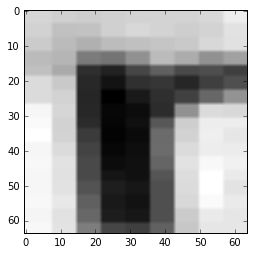

1/1 [==============================] - 0s
Evaluated letter: r
Actual letter: r


/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


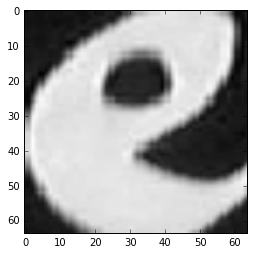

1/1 [==============================] - 0s
Evaluated letter: e
Actual letter: e


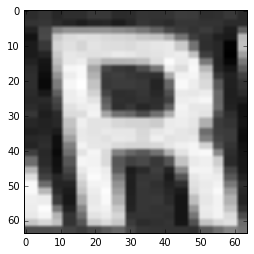

1/1 [==============================] - 0s
Evaluated letter: R
Actual letter: R


In [14]:
for i in np.random.randint(0,len(X_train),3):
    plt.imshow(X_train[i].reshape(64,64))
    plt.gray()
    plt.show()
    print 'Evaluated letter: '+letters[model.predict_classes(X_train[i].reshape(1,1,64,64))]
    print 'Actual letter: '+letters[np.argmax(y_train[i])]

In [17]:
create_submission(model)

Loading images, it may take a while
------------------
Predicting classes
6220/6220 [==============================] - 126s   
------------------
Saving submission
------------------
Done
